In [10]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [11]:
%run cardiac_ml_tools.py

<Figure size 640x480 with 0 Axes>

In [3]:
!source /content/download_intracardiac_dataset.sh

Streaming output truncated to the last 5000 lines.
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/VmData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.1000.innerindex.4.volunteer.v1.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.60.volunteer.v6.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/VmData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.16.volunteer.v1.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.8.volunteer.v9.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.16.volunteer.v12.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/VmData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.1000.innerindex.26.volunteer.v9.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/VmData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.600.innerindex.15.volunteer.v2.npy
data_hearts_dd_0p2_geo_inn_act_2_bcl_I/pECGData_hearts_dd_0p2_geo_inn_act_2_bcl_I_bcl.1000.innerindex.10.volu

In [13]:
data_dirs = []
regex = r"data_hearts_dd_0p2*"
DIR = "intracardiac_dataset/"
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print("Number of file pairs: {}".format(len(file_pairs)))

Number of file pairs: 16117


In [12]:
case = 321
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {
    1: 1,
    2: 5,
    3: 9,
    4: 2,
    5: 6,
    6: 10,
    7: 3,
    8: 7,
    9: 11,
    10: 4,
    11: 8,
    12: 12,
}  # reorder the leads to standard 12-lead ECG display

print("Case {} : {}".format(case, file_pairs[case][0]))
pECGData_example = np.load(file_pairs[case][0])
pECGData_example = get_standard_leads(pECGData_example)


Case 321 : intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_1_bcl/pECGData_hearts_dd_0p2_geo_inn_act_1_bcl_bcl.600.innerindex.38.volunteer.v14.npy


<Figure size 1000x700 with 0 Axes>

In [14]:
# Iterates trough dataset, creating two tensors: One of 12 leads x 500ms, and one of the 16000 x 75 x 1 activation map
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

pECGData_list = []
ActTime_list = []

file_pairs = file_pairs[:3000]

for pair in tqdm(file_pairs, desc="Processing pairs"):
    pECGData_sample = np.load(pair[0])
    pECGData_sample = get_standard_leads(pECGData_sample)  # Corrected from pECGData_example to pECGData_sample
    VmData_sample = np.load(pair[1])
    ActTime_sample = get_activation_time(VmData_sample)

    pECGData_list.append(pECGData_sample)
    ActTime_list.append(ActTime_sample)

pECGData_array = np.array(pECGData_list)
ActTime_array = np.array(ActTime_list)

X_flat = pECGData_array.reshape(pECGData_array.shape[0], -1)



Processing pairs: 100%|██████████| 3000/3000 [00:19<00:00, 151.61it/s]


In [15]:
from sklearn.model_selection import train_test_split

# Flatten the input data for XGBoost (since XGBoost does not handle multi-dimensional input directly)
X_flat = pECGData_array.reshape(pECGData_array.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, ActTime_array, test_size=0.3, random_state=42)


In [16]:
import xgboost as xgb

# Reshape labels to remove the extra dimension
y_train_reshaped = y_train.reshape(y_train.shape[0], -1)
y_test_reshaped = y_test.reshape(y_test.shape[0], -1)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_reshaped)
dtest = xgb.DMatrix(X_test, label=y_test_reshaped)


In [17]:
# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.3,
    'subsample': 0.7,
    'colsample_bytree': 0.7
}

# Number of boosting rounds
num_boost_round = 5

# Callback function to use tqdm
class TqdmCallback(xgb.callback.TrainingCallback):
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Training Progress")

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        if epoch + 1 == self.pbar.total:
            self.pbar.close()
        return False


bst = xgb.train(params, dtrain, num_boost_round=num_boost_round, callbacks=[TqdmCallback(num_boost_round)])



Training Progress: 100%|██████████| 5/5 [11:38<00:00, 139.74s/it]


In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
# Make predictions
preds_train = bst.predict(dtrain)
preds_test = bst.predict(dtest)

# Reshape y_true to be 2D
y_train_reshaped = y_train.reshape(y_train.shape[0], -1)
y_test_reshaped = y_test.reshape(y_test.shape[0], -1)

# Calculate Mean Squared Error
mse_train = mean_squared_error(y_train_reshaped, preds_train) # Use reshaped y_train
mse_test = mean_squared_error(y_test_reshaped, preds_test) # Use reshaped y_test

print(f"Train Mean Squared Error: {mse_train:.4f}")
print(f"Test Mean Squared Error: {mse_test:.4f}")


print("Predictions:", preds_test[:5])
print("Actual values:", y_test_reshaped[:5])

Train Mean Squared Error: 127.8200
Test Mean Squared Error: 214.2079
Predictions: [[ 45.910233  38.473442  42.19123   25.867119  42.78205   44.19945
   34.63356   35.19507   27.379128  41.31464   45.03506   48.877537
   45.674004  61.322224  54.99648   56.522785  70.980545  64.625916
   56.925117  55.310158  61.198757  60.1913    56.545544  65.56606
   68.47191   62.3404    64.26635   47.321945  45.008045  49.380257
   53.989178  60.488945  64.80409   46.246872  46.748344  45.12718
   42.406094  57.636555  52.244907  34.127663  42.202812  41.667496
   45.4512    45.89077   53.895195  56.04746   61.197933  55.13151
   65.542336  59.413994  56.262764  65.225815  73.175354  76.0747
   84.096146  82.45268   87.44663   86.721306  76.34047   83.03686
   72.74439   70.143616  70.1908    85.0884    76.82459   78.69684
   84.20832   73.375336  80.67633   67.027054  70.81085   59.389004
   76.06161   76.36526   75.91677 ]
 [ 18.646362  17.416126  14.222131  15.174588  18.291693  26.745876
   23.


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-rmse:25.50277



Training Progress:  20%|██        | 1/5 [02:20<09:22, 140.57s/it]

[1]	train-rmse:19.86284



Training Progress:  40%|████      | 2/5 [04:37<06:56, 138.68s/it]

[2]	train-rmse:15.91718



Training Progress:  60%|██████    | 3/5 [06:54<04:35, 137.89s/it]

[3]	train-rmse:13.20506



Training Progress:  80%|████████  | 4/5 [09:12<02:17, 137.95s/it]

[4]	train-rmse:11.30575



Training Progress:  20%|██        | 1/5 [40:19<2:41:18, 2419.62s/it]


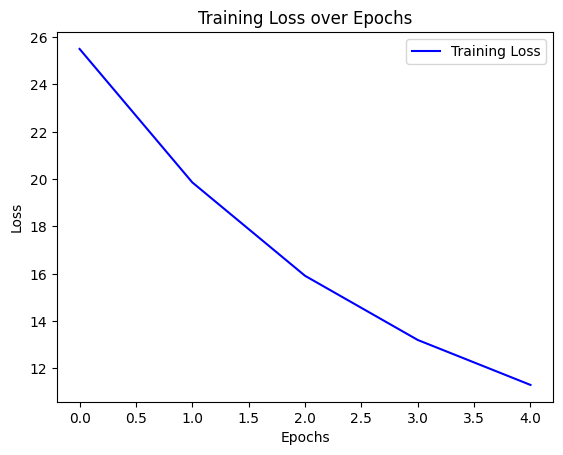

[25.502765445728283, 19.862836891477638, 15.917176810403385, 13.205061415096338, 11.30575183858728]


In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# ... (previous code remains the same)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.3,
    'subsample': 0.7,
    'colsample_bytree': 0.7
}

# Number of boosting rounds
num_boost_round = 5

# Initialize a list to store training losses
train_losses = []


class TqdmCallback(xgb.callback.TrainingCallback):
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Training Progress")

    def after_iteration(self, model, epoch, evals_log):
        # Collect training loss
        train_losses.append(evals_log['train']['rmse'][-1])
        self.pbar.update(1)
        if epoch + 1 == self.pbar.total:
            self.pbar.close()
        return False


bst = xgb.train(params, dtrain, num_boost_round=num_boost_round,
                 callbacks=[TqdmCallback(num_boost_round)],
                 evals=[(dtrain, 'train')])


def plot_losses(train_losses):
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss over Epochs')
    plt.show()

plot_losses(train_losses)
print(train_losses)